# Final Jupyter Notebook for Brief Display of Results 

### By Gabriel Thompson and Ethan Blair

Most of the code writing that we did was adaptation on code from the paper [Flow Factorized Representation Learning](https://arxiv.org/abs/2309.13167) at [this repository](https://github.com/KingJamesSong/latent-flow). It was heavily research-grade code, so getting it to run at all took a lot of work in the first place. 

We were looking to apply this method in the paper to a different dataset in order to have qualitative results for the learned transformations in latent space. Our original target dataset was audio data from the [NSynth dataset](https://magenta.tensorflow.org/datasets/nsynth). We sunk a lot of time into writing code for preprocessing audio data and converting it to spectrograms. Sadly, we realized afterwards that reconstruction of audio data from solely the magnitude spectrogram is not a trivial task. Though we could compare some sort of L2 loss between the ground truth and reconstructed spectrogram magnitude plots, we would not be able to listen to the reconstructed audio and receive qualitative feedback on the learned transformations. We looked into algorithms for estimating the missing phase component to reconstruct audio data from just the magnitude spectrum, but this yielded distorted audio data. 

Because of this, we decided to pivot to the [FashionMNIST](https://pytorch.org/vision/0.19/generated/torchvision.datasets.FashionMNIST.html) image dataset. The goal of this project was to learning more about representation learning and work being done on understanding the latent space, such as disentanglement. We felt that getting this code up and running and trying it on a new dataset would be a good way to get our hands dirty without taking on a project that was too ambitious.

In [1]:
import torch
import os
import numpy as np
from matplotlib import pyplot as plt

# Specify the path to the model 
exp_path_fmnist = "/home/gathomp3/Deep_Learning/latent_flow_project/latent-flow/experiments/wip/VAE_MNIST-K3-D16_5"

# Specify the path to the checkpoint file
checkpoint_file = os.path.join(exp_path_fmnist, "models/checkpoint.pt")

# Load the checkpoint
checkpoint = torch.load(checkpoint_file)

/tmp/ipykernel_2220193/3813827460.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


## Model Description

A standard VAE is trained that maps images $\mathbf{x}$ to latents $\mathbf{z}$. 

In [ ]:
checkpoint["vae"].keys()

odict_keys(['encoder.encoder.0.weight', 'encoder.encoder.0.bias', 'encoder.encoder.2.weight', 'encoder.encoder.2.bias', 'encoder.encoder.4.weight', 'encoder.encoder.4.bias', 'encoder.encoder.6.weight', 'encoder.encoder.6.bias', 'encoder.encoder.8.weight', 'encoder.encoder.8.bias', 'encoder.linear_means.weight', 'encoder.linear_means.bias', 'encoder.linear_log_var.weight', 'encoder.linear_log_var.bias', 'decoder.decoder.0.weight', 'decoder.decoder.0.bias', 'decoder.decoder.3.weight', 'decoder.decoder.3.bias', 'decoder.decoder.5.weight', 'decoder.decoder.5.bias', 'decoder.decoder.7.weight', 'decoder.decoder.7.bias', 'decoder.decoder.9.weight', 'decoder.decoder.9.bias', 'decoder.decoder.11.weight', 'decoder.decoder.11.bias'])

Coefficients $\mu$ and $\sigma$ are learned for each transformations that control the evolution of the prior over time

In [22]:
checkpoint["prior"].keys()

odict_keys(['MLP_SET.0.mu', 'MLP_SET.0.sigma', 'MLP_SET.1.mu', 'MLP_SET.1.sigma', 'MLP_SET.2.mu', 'MLP_SET.2.sigma'])

MLP's are used to parameterize a learned potential $\psi^k$ which define a flow through latent space corresponding to a transformation $k$. This is seen below as `MLP_SET.0`, corresponding to $\psi^0$ for the scaling transformation specifically. Additionally, another MLP is used to enforce transport of the posterior flow. Specifically, the potential is encouraged to satisfy the Hamilton-Jacobi equation subject to an external driving force (detailed in section 3.4 of the paper). This MLP is seen below as `FORCE_SET`, with the number again relating to each transformation.

During inference, these learned potentials are used 

In [30]:
list(checkpoint["support_sets"].keys())

['MLP_SET.0.layer_x.weight',
 'MLP_SET.0.layer_x.bias',
 'MLP_SET.0.layer_time.weight',
 'MLP_SET.0.layer_time.bias',
 'MLP_SET.0.layer_time2.weight',
 'MLP_SET.0.layer_time2.bias',
 'MLP_SET.0.layer_fusion.weight',
 'MLP_SET.0.layer_fusion.bias',
 'MLP_SET.0.layer_out.weight',
 'MLP_SET.0.layer_out.bias',
 'MLP_SET.1.layer_x.weight',
 'MLP_SET.1.layer_x.bias',
 'MLP_SET.1.layer_time.weight',
 'MLP_SET.1.layer_time.bias',
 'MLP_SET.1.layer_time2.weight',
 'MLP_SET.1.layer_time2.bias',
 'MLP_SET.1.layer_fusion.weight',
 'MLP_SET.1.layer_fusion.bias',
 'MLP_SET.1.layer_out.weight',
 'MLP_SET.1.layer_out.bias',
 'MLP_SET.2.layer_x.weight',
 'MLP_SET.2.layer_x.bias',
 'MLP_SET.2.layer_time.weight',
 'MLP_SET.2.layer_time.bias',
 'MLP_SET.2.layer_time2.weight',
 'MLP_SET.2.layer_time2.bias',
 'MLP_SET.2.layer_fusion.weight',
 'MLP_SET.2.layer_fusion.bias',
 'MLP_SET.2.layer_out.weight',
 'MLP_SET.2.layer_out.bias',
 'FORCE_SET.0.layer_x.weight',
 'FORCE_SET.0.layer_x.bias',
 'FORCE_SET.0.la

Helper functions for files. Note: These were written by an LLM.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
from pathlib import Path
from PIL import Image

def display_image_grid(images, titles=None, figsize=(15, 15), grid_size=None):
    """
    Display a list of images in a custom grid layout using matplotlib.
    
    Parameters:
    -----------
    images : list
        List of images (numpy arrays)
    titles : list, optional
        List of titles for each image
    figsize : tuple, optional
        Figure size (width, height) in inches
    grid_size : tuple, optional
        Number of rows and columns (n_rows, n_cols)
        If None, automatically calculates based on number of images
    """
    
    n_images = len(images)
    
    # Set grid dimensions
    if grid_size is None:
        # Default automatic sizing
        if n_images <= 3:
            n_cols = n_images
            n_rows = 1
        else:
            n_cols = min(4, int(np.ceil(np.sqrt(n_images))))
            n_rows = int(np.ceil(n_images / n_cols))
    else:
        n_rows, n_cols = grid_size
        if n_rows * n_cols < n_images:
            raise ValueError(f"Grid size {grid_size} is too small for {n_images} images")
    
    # Create figure and subplots
    fig = plt.figure(figsize=figsize)
    
    for idx, image in enumerate(images):
        if idx >= n_rows * n_cols:  # Skip if we've run out of grid space
            print(f"Warning: Only showing first {n_rows * n_cols} images")
            break
            
        ax = fig.add_subplot(n_rows, n_cols, idx + 1)
        
        # Check if image is grayscale
        if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
            
        # Add title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
            
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    return fig


def read_images_from_directory(directory_path, supported_formats=None, sort=True):
    """
    Read all supported images from a directory and return them as a list of numpy arrays.
    
    Parameters:
    -----------
    directory_path : str or Path
        Path to the directory containing images
    supported_formats : list, optional
        List of supported file extensions (e.g., ['.jpg', '.png'])
        If None, defaults to common image formats
    sort : bool, optional
        Whether to sort the images by filename (default: True)
    
    Returns:
    --------
    tuple
        (list of numpy arrays, list of filenames, list of failed files)
    """
    if supported_formats is None:
        supported_formats = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']
    
    # Convert to Path object for better path handling
    directory = Path(directory_path)
    
    if not directory.exists():
        raise FileNotFoundError(f"Directory not found: {directory}")
    if not directory.is_dir():
        raise NotADirectoryError(f"Path is not a directory: {directory}")
    
    # Initialize lists to store results
    images = []
    filenames = []
    failed_files = []
    
    # Get all files in directory
    files = [f for f in directory.iterdir() if f.is_file()]
    if sort:
        files.sort()
    
    # Process each file
    for file_path in files:
        # Check if file extension is supported
        if file_path.suffix.lower() in supported_formats:
            try:
                # Open and convert image to numpy array
                with Image.open(file_path) as img:
                    # Convert RGBA to RGB if necessary
                    if img.mode == 'RGBA':
                        img = img.convert('RGB')
                    # Convert to numpy array
                    img_array = np.array(img)
                    images.append(img_array)
                    filenames.append(file_path.name)
            except Exception as e:
                failed_files.append((file_path.name, str(e)))
    
    if not images:
        print(f"No valid images found in {directory}")
        if failed_files:
            print("Failed files:")
            for file, error in failed_files:
                print(f"- {file}: {error}")
    
    return images, filenames, failed_files


In [83]:
images_path_1 = "/home/gathomp3/Deep_Learning/latent_flow_project/latent-flow/experiments/wip/VAE_MNIST-K3-D16_5/results/VAE_MNIST_VIS/32_1.0_32.0/2b595bf2623ab37e33797b1bc32d86ec40286efe/paths_images/path_000"
images_path_2 = "/home/gathomp3/Deep_Learning/latent_flow_project/latent-flow/experiments/wip/VAE_MNIST-K3-D16_5/results/VAE_MNIST_VIS/32_1.0_32.0/2b595bf2623ab37e33797b1bc32d86ec40286efe/paths_images/path_001"
images_path_3 = "/home/gathomp3/Deep_Learning/latent_flow_project/latent-flow/experiments/wip/VAE_MNIST-K3-D16_5/results/VAE_MNIST_VIS/32_1.0_32.0/2b595bf2623ab37e33797b1bc32d86ec40286efe/paths_images/path_002"

We see that the model learns some transformations better than others. For the latter two (rotation and coloring), it gets a bit confused at first with the transformations. We can see this with the slight color shift before rotation in the second image and the slight rotation before coloring in the third image. 

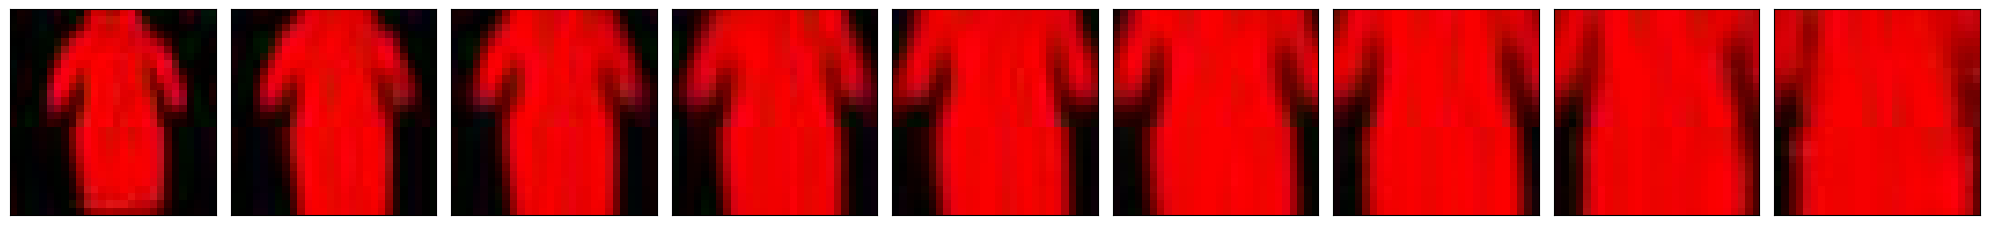

In [91]:
imgs, _, _ = read_images_from_directory(images_path_1)
display_image_grid(imgs[8:], figsize=(20,5), grid_size=(1,9))
plt.show()

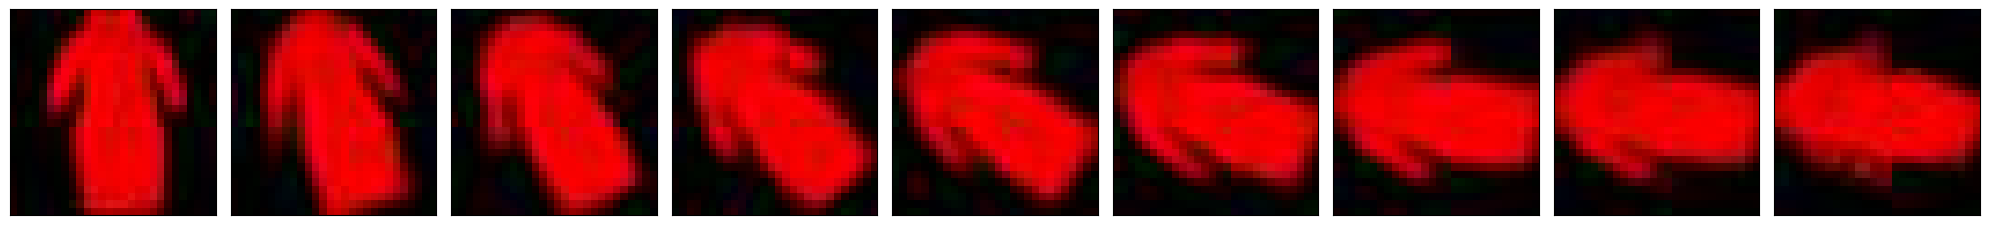

In [92]:
imgs, _, _ = read_images_from_directory(images_path_2)
display_image_grid(imgs[8:], figsize=(20,5), grid_size=(2,9))
plt.show()

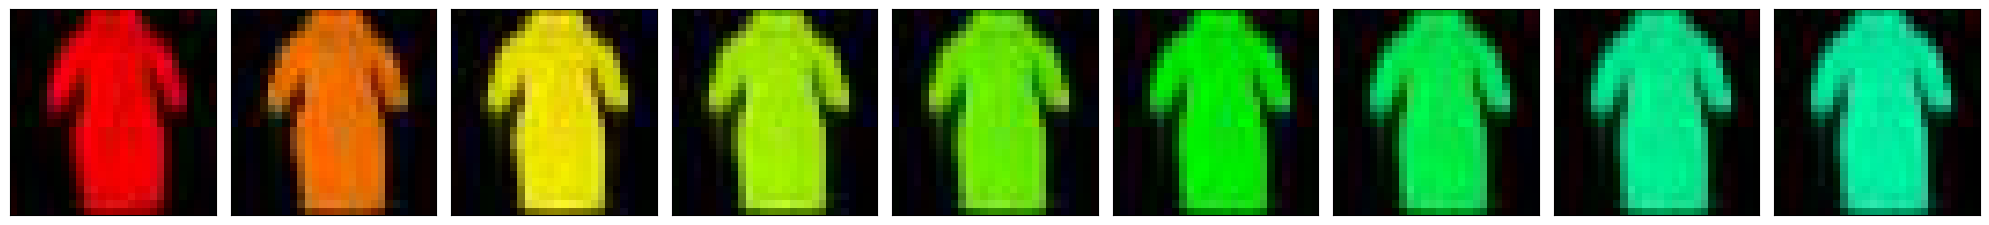

In [93]:
imgs, _, _ = read_images_from_directory(images_path_3)
display_image_grid(imgs[8:], figsize=(20,5), grid_size=(2,9))
plt.show()

We note that some of the latent transformations are not as clear as others for other images. Likely, this can be fixed through more training time and finagling with the hyperparameters. The main purpose of this project was to get a feel for the approach and see if it could be applied to a different dataset. 